## Imports

In [1]:
import os
import time
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix

In [2]:
tf.VERSION

'1.4.1'

## PATH Setting

In [3]:
ROOT_PATH = os.path.expanduser('~')
DATA_PATH = os.path.join(ROOT_PATH, 'dataset')
MNIST_PATH = os.path.join(DATA_PATH, 'mnist')
PREJECT_PATH = os.getcwd()
MODELS_PATH = os.path.join(PREJECT_PATH, 'models/mnist')

## Load MNIST Data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets(MNIST_PATH)
# Load training and eval data
train_data = data.train.images # Returns np.array
train_labels = data.train.labels
valid_data = data.validation.images # Returns np.array
valid_labels = data.validation.labels
test_data = data.test.images
test_labels = data.test.labels

Extracting /home/woodylin/dataset/mnist/train-images-idx3-ubyte.gz
Extracting /home/woodylin/dataset/mnist/train-labels-idx1-ubyte.gz
Extracting /home/woodylin/dataset/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/woodylin/dataset/mnist/t10k-labels-idx1-ubyte.gz


In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))
print("- Input data shape\t{}".format(data.train.images.shape))
print("- Output data shape\t{}".format(data.test.labels.shape))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000
- Input data shape	(55000, 784)
- Output data shape	(10000,)


## Data Dimensions

In [6]:
img_size     = 784
img_shape    = (28, 28)
num_channels = 1
num_classes  = 10

## Helper function for plotting images

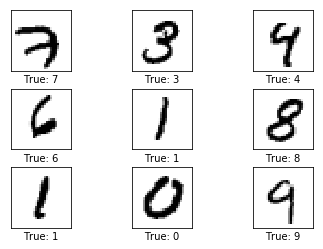

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
# test function
plot_images(train_data[:9], train_labels[:9])

## Convolution Network

In [8]:
# Create the neural network# Creat 
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

In [9]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [10]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn, model_dir=MODELS_PATH)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_service': None, '_log_step_count_steps': 100, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_model_dir': '/home/woodylin/tensorflow3/Udacity_self_driving_car/Udacity_Notebook/models/mnist', '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_session_config': None, '_task_id': 0, '_task_type': 'worker', '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe5ec8475c0>, '_master': ''}


In [11]:
# Training Parameters# Train 
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': train_data}, y=train_labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /home/woodylin/tensorflow3/Udacity_self_driving_car/Udacity_Notebook/models/mnist/model.ckpt.
INFO:tensorflow:loss = 2.3263135, step = 1
INFO:tensorflow:global_step/sec: 12.3774
INFO:tensorflow:loss = 0.15098184, step = 101 (8.080 sec)
INFO:tensorflow:global_step/sec: 12.2569
INFO:tensorflow:loss = 0.15142111, step = 201 (8.159 sec)
INFO:tensorflow:global_step/sec: 12.3868
INFO:tensorflow:loss = 0.04779297, step = 301 (8.073 sec)
INFO:tensorflow:global_step/sec: 12.4178
INFO:tensorflow:loss = 0.038057916, step = 401 (8.053 sec)
INFO:tensorflow:global_step/sec: 12.4295
INFO:tensorflow:loss = 0.027334906, step = 501 (8.045 sec)
INFO:tensorflow:global_step/sec: 12.357
INFO:tensorflow:loss = 0.010292676, step = 601 (8.093 sec)
INFO:tensorflow:global_step/sec: 12.4755
INFO:tensorflow:loss = 0.024497136, step = 701 (8.016 sec)
INFO:tensorflow:global_step/sec: 12.3957
INFO:tensorflow:loss = 0.09965493, s